# Updated Random Forest Code

Streamlining the process and ensuring analysis includes appropriate measures.

In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from scipy.stats import sem

%matplotlib inline
plt.style.use('seaborn-colorblind')

## Import the data and the question strings

In [2]:
folder='../../ComputationSurveyData/';
XLS = pd.ExcelFile(folder + 'LabeledComputationData.xlsx')
XLS2 = pd.ExcelFile(folder + 'CategorizedQuestions.xlsx')
df = XLS.parse('LabeledComputationData')
questions = XLS2.parse('Sheet1')

### Selecting the question to classify and input features to use to predict classifications

In [3]:
question_to_classify = 'Q1'

class_names = ['Teach\nComputation','Do Not Teach\nComputation']

feature_subset = questions[(questions['context'] == 'background') & (questions['qtype'] != 'open')]

print(feature_subset['id'])

151    Q152
152    Q153
153    Q154
154    Q155
155    Q156
156    Q157
157    Q158
159    Q160
161    Q162
162    Q163
163    Q164
165    Q166
167    Q168
168    Q169
184    Q185
185    Q186
186    Q187
Name: id, dtype: object


### Randomly select the training data
Add a new key ```is_train``` to the data frame, which is a random selection of the data

In [4]:
training_proportion = .75
df['is_train'] = np.random.uniform(0, 1, len(df)) <= training_proportion

### Add new keys that factorize our original data set
The classifer requires that the data be represented as numbers, so it will assign a unique integer for each unique string in a given key.

In [5]:
features = []
for ID in feature_subset.id:

    new_header = ID + 'feature'
    df[new_header] = pd.factorize(df[ID])[0]
    features.append(new_header)

### Create two new dataframes, one with the training rows, one with the test rows

In [6]:
train, test = df[df['is_train'] == True], df[df['is_train'] == False]

### Create two new data frames for the classifications and store the input data
```train[question]``` contains the classes of the data. Before we can use it, we need to convert each result into a digit. 

In [7]:
y = pd.factorize(train[question_to_classify])[0]
y_test = pd.factorize(test[question_to_classify])[0]
X = train[features]
X_test = test[features]

# Rescale the input data
Scaling of the data (using z-scores) ensures that each values for each key are on the same scale so that fits aren't overwhelmed by vastly different scaled variables.

In [8]:
# Scaling to ensure it doesn't behave badly
scaler = StandardScaler()
scaler.fit(X)

# Now apply the transformations to the data:
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Run the random forest and fit the data

In [9]:
# Create a random forest classifier. By convention, clf means 'classifier'
## Weighted due to imbalance in classes
clf = RandomForestClassifier(n_estimators = 256, criterion = 'entropy', n_jobs=-1, class_weight={0:6,1:4});

# Train the classifier to take the training features, X, and learn how they relate
# to the training classes, y
clf.fit(X, y);

# Apply the classifier we trained to the test data (which, remember, it has never seen before)
pred_y_test = clf.predict(X_test);

fs = feature_subset['feature'].tolist()

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
stderr = sem([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)

for feature in zip(fs, importances):
    print(feature)

('Q152feature', 0.021243167509271584)
('Q153feature', 0.033548618451023381)
('Q154feature', 0.027548255253635016)
('Q155feature', 0.22851876351984735)
('Q156feature', 0.031088629098350647)
('Q157feature', 0.042337654412743633)
('Q158feature', 0.039771288366232276)
('Q160feature', 0.03439725207468082)
('Q162feature', 0.027827901187243251)
('Q163feature', 0.087504889545468451)
('Q164feature', 0.064490799880791844)
('Q166feature', 0.088734266595576108)
('Q168feature', 0.021553396521505966)
('Q169feature', 0.049583758456408895)
('Q185feature', 0.01586770499046207)
('Q186feature', 0.11446207581254619)
('Q187feature', 0.071521578324212479)


### Run analytics on the model

In [10]:
## Confusion Matrix
cnf_matrix = confusion_matrix(y_test,pred_y_test)
print('Confusion Matrix:\n',cnf_matrix)

## Check accuracy of model on test data
acc_score = accuracy_score(y_test, pred_y_test);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf.predict_proba(X_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

Confusion Matrix:
 [[ 81  36]
 [ 50 129]]
Percentage of accurate predictions:
 0.709459459459
Area under curve:
 0.775366470897


Confusion matrix, without normalization
[[ 81  36]
 [ 50 129]]
Normalized confusion matrix
[[ 0.69230769  0.30769231]
 [ 0.27932961  0.72067039]]


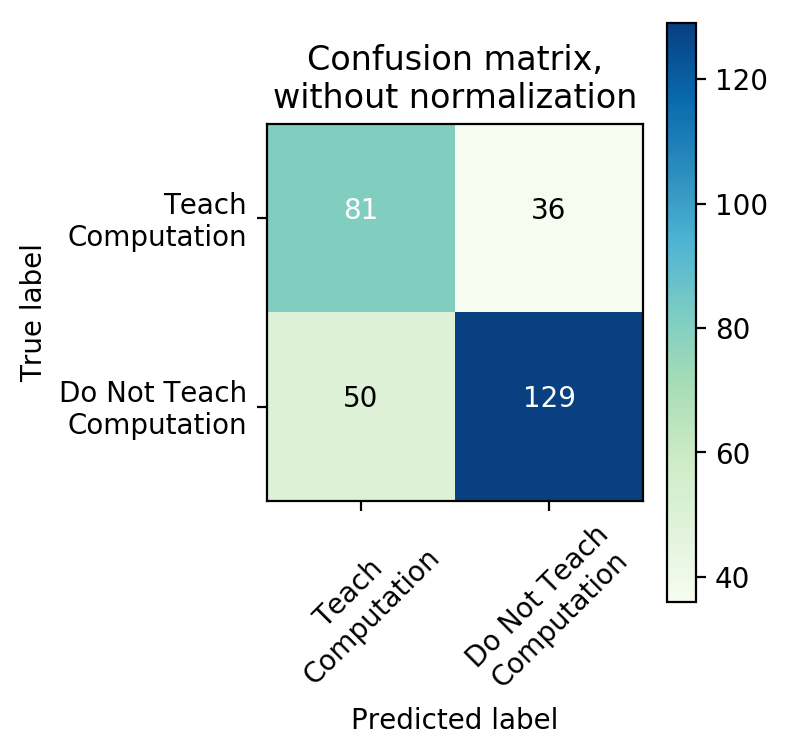

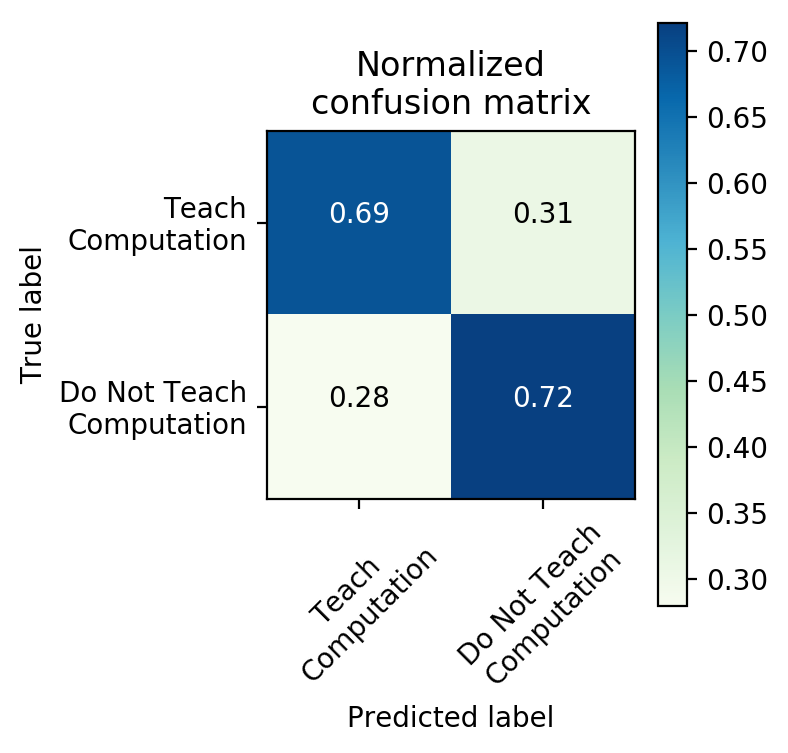

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix,\nwithout normalization')
plt.tight_layout()

# Plot normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized\nconfusion matrix')
plt.tight_layout()

In [12]:
tags = []

for i in range(len(features)):
            
    tags.append(questions[questions['feature'] == fs[indices[i]]]['shortname'].values[0])

(-1, 17)

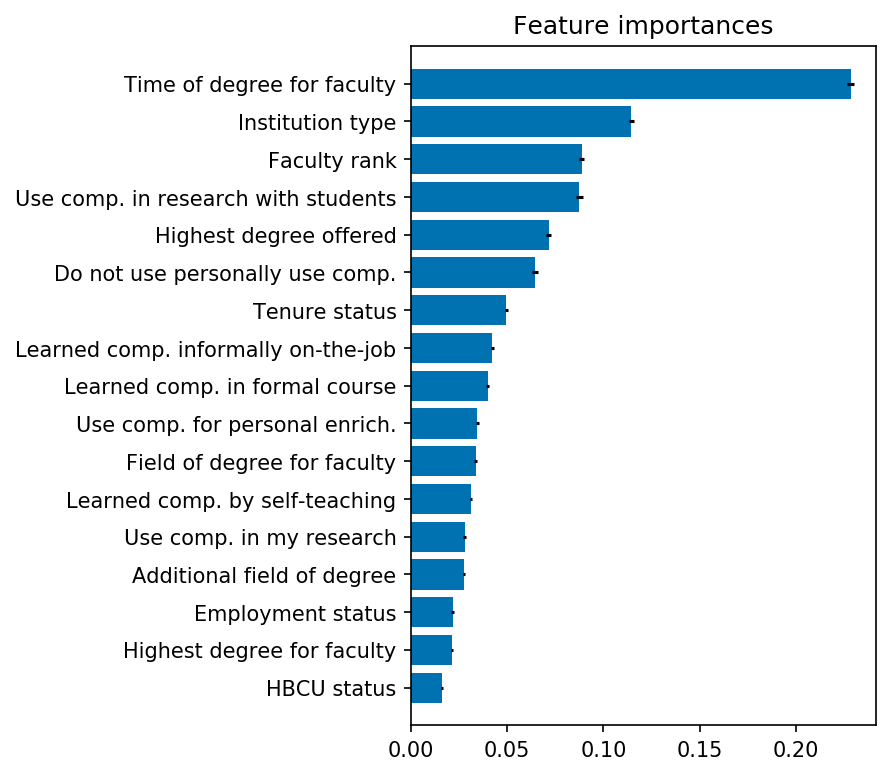

In [13]:
plt.figure(num=None, figsize=(4, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices], xerr=stderr[indices], align="center")
plt.yticks(range(X.shape[1]), tags)
plt.ylim([-1, X.shape[1]])

### Plot the ROC curve

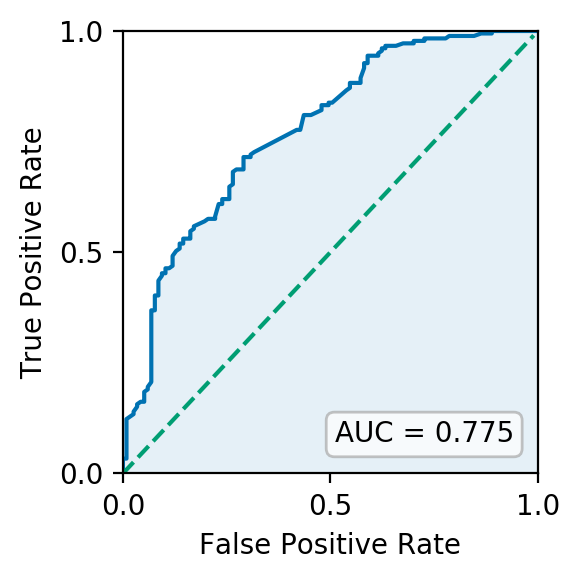

In [14]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC['fpr'],dfROC['tpr'],'-')
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC['fpr'], 0, dfROC['tpr'],alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()

## Feature Selection (reduction of space)

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.05
sfm = SelectFromModel(clf, threshold=0.05);

# Train the selector
sfm.fit(X, y);

In [ ]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(fs[feature_list_index])

In [ ]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X)
X_important_test = sfm.transform(X_test)

In [ ]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=2048, random_state=0, 
                                       n_jobs=-1, criterion = 'entropy', 
                                       class_weight={0:2,1:1});

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y);

In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

In [ ]:
## Confusion Matrix
cnf_matrix_reduced = confusion_matrix(y_test,y_important_pred)
print('Confusion Matrix:\n',cnf_matrix_reduced)

## Check accuracy of model on test data
acc_score_reduced = accuracy_score(y_test, y_important_pred);
print('Percentage of accurate predictions:\n', acc_score_reduced)

## Compute predicted class probabilities
preds_reduced = clf_important.predict_proba(X_important_test)

## Determine false positive and true positive rate
fpr_reduced, tpr_reduced, thresholds_reduced = roc_curve(y_test, preds_reduced[:,1])

## Store rates for plotting
dfROC_reduced = pd.DataFrame(dict(fpr = fpr_reduced, tpr = tpr_reduced))

## Compute area under curve of ROC
area_under_curve_reduced = auc(fpr_reduced,tpr_reduced)
print('Area under curve:\n', area_under_curve_reduced)

# Plot non-normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix_reduced, classes=class_names,
                      title='Confusion matrix,\nwithout normalization')
plt.tight_layout()

# Plot normalized confusion matrix
plt.figure(figsize = (4,4), dpi = 200)
plot_confusion_matrix(cnf_matrix_reduced, classes=class_names, normalize=True,
                      title='Normalized\nconfusion matrix')
plt.tight_layout()

In [ ]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC_reduced['fpr'],dfROC_reduced['tpr'],'-')
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC_reduced['fpr'], 0, dfROC_reduced['tpr'], alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve_reduced, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()